# Assignment 9: Causal Inference (Part 2)

## Objective:

Causal inference is the process of drawing a conclusion about a causal connection based on the conditions of the occurrence of an effect. It is a very powerful and widely-used tool in real-world applications and scenarios. In this assignment, you are expected to apply the basic concepts of causal inference to solve problems on real datasets and be able to achieve the following goals.

* Understand why causality is needed.
* Understand what is causality, particularly the difference between causality and correlation.
* Understand how to estimate counterfactual results.
* Understand how to use the graphical model to represent causality.
* Can use some tools (e.g., dowhy) to infer causality, express causality and estimate treatment effects.

# 0. Preparation

In [156]:
import numpy as np
import pandas as pd
from dataprep.eda import plot
pd.options.mode.chained_assignment = None

In this assignment, you are going to use the [Lalonde](lalonde.csv) dataset. Each tuple in the dataset represents an individual who was enrolled (or not enrolled) in a job training program. It aims to evaluate the effectiveness of a job training program (the treatment variable) on the real earnings of an individual, after completing the program for years. 

The dataset consists of a number of demographic variables, like age, race, academic background, marriage status, and previous real earnings in 1974, 1975 as well as a treatment indicator, and the real earnings in the year 1978 (the outcome variable).

In [157]:
lalonde = pd.read_csv('lalonde.csv', index_col=0)
lalonde.head(-5)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899
...,...,...,...,...,...,...,...,...,...,...
PSID420,0,39,2,1,0,1,1,0.0,0.0,964.9555
PSID421,0,55,8,0,0,1,1,0.0,0.0,0.0000
PSID422,0,16,9,0,0,0,1,0.0,0.0,5551.8190


In [158]:
# plot(lalonde)

## Task 1. Causal Graph 
In this task, you will draw a causal graph on a real-world dataset based on the information given. Please remind yourself of the difference between causality and correlation.

In [159]:
#import graphviz, the python tool we are going to use for this task
from graphviz import Digraph

In the Lalonde dataset, `treat` is the treatment attribute, which represents whether an individual was enrolled in the job training program or not. `re78` is the outcome attribute. `age` and `married` are confounding variables. Please draw the causal graph for these four attributes using Graphviz.

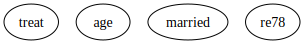

In [160]:
dot = Digraph(comment='The causal graph for Lalonde')
dot.node('a','treat')
dot.node('b','age')
dot.node('c','married')
dot.node('d','re78')

dot

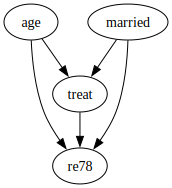

In [161]:
#<-- Write Your Code -->
#Implement your plot function here and show the graph, the output should be a causal graph

dot.edge('a', 'd')
dot.edge('b', 'a')
dot.edge('c', 'a')
dot.edge('c', 'd')
dot.edge('b', 'd')

dot


## Task 2. ATE Estimation
In this task, your job is to implement different ATE estimation approaches and draw useful conclusions.

### 2.1 Perfect Matching
For the PSID tuples in the dataset (i.e., those individuals who weren't enrolled in the job training program), please use perfect matching to estimate their salaries if they received treatments.


In [162]:
def find_first_match_row(df, x):
    # Drop the treatment column and the target column from x
    x_modified = x.drop(labels=['treat', 're78'])
    
    # Drop the treatment column and the target column
    temp_df = df.drop(columns=['treat', 're78'])

    # Find the first row of treatment_df that matches x. x is a row of the lalonde dataset
    for i in range(len(temp_df)):
        if temp_df.iloc[i].equals(x_modified):
            # return the row of the first match
            return df.iloc[i]['re78']
    return -1

In [163]:
#<-- Write Your Code -->

# Implement the perfect matching method here and output the count of PSID tuples whose counterfactual can be computed
# using perfect matching, as well as the percentage of such tuples among all PSID tuples. If there are multiple 
# tuples in the treatment group that can be matched with the control group, just select the first one
# output: count and percentage

control_df = lalonde[lalonde['treat'] == 0]
treatment_df = lalonde[lalonde['treat'] == 1]

# Create control_df with counterfactual re78
control_df['perfect match counterfactual re78'] = control_df.apply(lambda x: find_first_match_row(treatment_df, x), axis=1)


In [164]:
# Get the count of the number of counterfactuals that did not return -1
count = control_df[control_df['perfect match counterfactual re78'] != -1].shape[0]

# Get the percentage of the number of counterfactuals that did not return -1
percentage = count / control_df.shape[0]

In [165]:
# Run the following code to print out the result
print("Count of tuples which can be computed by perfect matching is " + str(count))
print("Percentage of such tuples among all PSID tuples is " + str(percentage))

Count of tuples which can be computed by perfect matching is 12
Percentage of such tuples among all PSID tuples is 0.027972027972027972


In [166]:
#<-- Write Your Code -->

# Compute ATE among those PSID tuples whose counterfactual can be computed using perfect matching
# output: value of ATE

perfect_matches = control_df[control_df['perfect match counterfactual re78'] != -1]
perfect_matches['diff'] = perfect_matches['perfect match counterfactual re78'] - perfect_matches['re78']
ATE = perfect_matches['diff'].mean()

In [167]:
# Run following code to print the result
print("ATE by perfect matching is " + str(ATE))

ATE by perfect matching is 1362.394


### 2.2 Nearest Neighbor Matching
For the PSID tuples in the dataset (i.e., those who weren't enrolled in the job training program), please use the nearest neighbor matching to estimate their salaries if they received treatments.

Please use all covariates (the attributes besides treatment and outcome) and use Euclidean distance as the distance metric.

In [191]:
#<-- Write Your Code -->

# Implement the nearest neighbor matching method here and output the count of PSID tuples whose counterfactual can be
# computed using nearest neighbor matching, when the threshold is set to 1000, as well as the percentage of such tuples among all PSID tuples
# Output: count and percentage

# Please use np.linalg.norm(x1 - x2) to compute the euclidean distance between two vectors

def nearest_neighbour(df, x):
    # Drop the treatment column and the target column from x
    x_modified = x.drop(labels=['treat', 're78'])
    
    # Drop the treatment column and the target column
    temp_df = df.drop(columns=['treat', 're78'])

    # Find the first row of treatment_df that matches x. x is a row of the lalonde dataset
    for i in range(len(temp_df)):
        if np.linalg.norm(temp_df.iloc[i] - x_modified) < 1000:
            # return the row of the first match
            return df.iloc[i]['re78']
    return -1

In [169]:
control_df = lalonde[lalonde['treat'] == 0]
treatment_df = lalonde[lalonde['treat'] == 1]

# Create control_df with nearest neighbour counterfactual re78
control_df['nearest neighbour counterfactual re78'] = control_df.apply(lambda x: nearest_neighbour(treatment_df, x), axis=1)

In [170]:
# Get the count of the number of counterfactuals that did not return -1
count = control_df[control_df['nearest neighbour counterfactual re78'] != -1].shape[0]

# Get the percentage of the number of counterfactuals that did not return -1
percentage = count / control_df.shape[0]

In [171]:
#run following code to print the result
print("Count of tuples which can be computed by nearest neighbor matching is " + str(count))
print("Percentage of such tuples among all PSID tuples is " + str(percentage))

Count of tuples which can be computed by nearest neighbor matching is 318
Percentage of such tuples among all PSID tuples is 0.7412587412587412


In [172]:
#<-- Write Your Code -->

# Compute ATE among those PSID tuples whose counterfactual can be computed using nearest neighbor matching
# Output: value of ATE

nearest_neighbour_matches = control_df[control_df['nearest neighbour counterfactual re78'] != -1]
nearest_neighbour_matches['diff'] = nearest_neighbour_matches['nearest neighbour counterfactual re78'] - nearest_neighbour_matches['re78']
ATE = nearest_neighbour_matches['diff'].mean()


In [173]:
# Run following code to print out the result
print("ATE by nearest neighbor matching is " + str(ATE))

ATE by nearest neighbor matching is 1304.973885062893


### 2.3 Propensity Score Matching
For the PSID tuples in the dataset (i.e., those weren't enrolled in the job training program), please use propensity score matching to estimate their salaries if they received treatments.

Please use logistic regression to fit the propensity score.

## What is Propensity Score?

The propensity score is the probability of a unit (e.g., individual, school, hospital) receiving a treatment given a set of observed covariates. It is typically estimated using logistic regression, where the treatment assignment is the dependent variable and the covariates are the independent variables. The logistic regression model estimates the probability (ranging from 0 to 1) of each unit being in the treatment group based on the covariates.

In [188]:
#<-- Write Your Code -->

# Compute propensity score P(y = 1|X) for each tuple in the dataset. Use logistic regression.
# Output: add the new column "psm" to lalonde dataframe

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = lalonde.drop(columns=['treat', 're78'])
y = lalonde['treat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

logisticRegr = LogisticRegression()

estimator = logisticRegr.fit(X_train, y_train)

# Evaluate the model on the test data
score = estimator.score(X_test, y_test)

# Add the new column 'psm' to lalonde dataframe
predictions = estimator.predict_proba(X)
lalonde['psm'] = predictions[:,1]

/Users/MichaelKuby/miniconda3/envs/dataPrep/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [190]:
# Run the following code to see the result
lalonde.head(-5)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,psm
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.430820
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.137950
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.739518
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.653304
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.703599
...,...,...,...,...,...,...,...,...,...,...,...
PSID420,0,39,2,1,0,1,1,0.0,0.0,964.9555,0.645551
PSID421,0,55,8,0,0,1,1,0.0,0.0,0.0000,0.068998
PSID422,0,16,9,0,0,0,1,0.0,0.0,5551.8190,0.161660


In [198]:
#<-- Write Your Code -->

# For each tuple in the control group, find the matching tuple in the treatment group, and then compute
# the ATE over the population
# Please match tuples with the metric |psm1 - psm2| to be minimum, threhold set to 0.01
# Output: the value of ATE, the count of tuples that can be matched, as well as the percentage

def psm_match(df, x):
    # Drop the treatment column and the target column from x
    x_modified = x.drop(labels=['treat', 're78'])
    
    # Drop the treatment column and the target column
    temp_df = df.drop(columns=['treat', 're78'])

    possible_matches = []

    # Find the first row of treatment_df that matches x. x is a row of the lalonde dataset
    for i in range(len(temp_df)):
        if abs(temp_df.iloc[i]['psm'] - x_modified['psm']) < 0.01:
            # add the matche to all possible matches
            possible_matches.append((i, abs(temp_df.iloc[i]['psm'] - x_modified['psm'])))
    
    if len(possible_matches) == 0:
        return -1
    else:
        # sort possible_matches by the second element of the tuple
        possible_matches = sorted(possible_matches, key=lambda x: x[1])
        # return the the re78 col of the first match
        return df.iloc[possible_matches[0][0]]['re78']


In [199]:
control_df = lalonde[lalonde['treat'] == 0]
treatment_df = lalonde[lalonde['treat'] == 1]

# Create control_df with counterfactual re78
control_df['psm match counterfactual re78'] = control_df.apply(lambda x: psm_match(treatment_df, x), axis=1)

In [200]:
# compute the count of control_df['psm match counterfactual re78'] that are not -1
count = control_df[control_df['psm match counterfactual re78'] != -1].shape[0]

# Compute the percentage of control_df['psm match counterfactual re78'] that are not -1
percentage = count / control_df.shape[0]

# Compute the ATE
psm_matches = control_df[control_df['psm match counterfactual re78'] != -1]
psm_matches['diff'] = psm_matches['psm match counterfactual re78'] - psm_matches['re78']
ATE = psm_matches['diff'].mean()

In [201]:
# Run the following code to print out the result
print("ATE by propensity score matching is " + str(ATE))
print("Count of tuples which can be computed by propensity score matching is " + str(count))
print("Percentage of such tuples among all PSID tuples is " + str(percentage))

ATE by propensity score matching is 315.8279335597826
Count of tuples which can be computed by propensity score matching is 368
Percentage of such tuples among all PSID tuples is 0.8578088578088578


### 2.4 Linear Regression
Train two individual models to fit P(y|t = 1,X) and P(y|t = 0,X), then infer the counterfactual outcome using two models while setting treatment to the opposite value. Infer the ATE over the population.

In [ ]:
#<-- Write Your Code -->

# Train two individual linear regression models and infer the counterfactual result for each tuple
# Output: the value of ATE, over the population



In [ ]:
# Run following code to print out the result
print("ATE by linear regression is " + str(ATE))

Please briefly discuss the advantages and disadvantages of the above four approaches.

**A.** [ADD YOUR ANSWER]

## Task 3. DoWhy
In this task, you are required to apply DoWhy and analyze the dataset using two ATE estimation methods.

In [ ]:
from dowhy import CausalModel
lalonde['treat'] = lalonde['treat'].astype(bool)
model = CausalModel(
        data = lalonde,
        treatment='treat',
        outcome='re78',
        common_causes='nodegree+black+hisp+age+educ+married'.split('+'))


In [ ]:
#<-- Write Your Code -->

# Use the linear regression and PSM methods provided by DoWhy to estimate ATE 
# Output: ATE_linear, ATE_psm



In [ ]:
# Run following code to print out the result
print("ATE by linear regression is " + str(ATE_linear))
print("ATE by psm is " + str(ATE_psm))

Briefly explain why the result by DoWhy is not same as the result by your own implementation.

**A.** [ADD YOUR ANSWER]

## Submission

Complete the code in this notebook, and submit it to the CourSys activity Assignment 9.